In [1]:
import copy
from pathlib import Path
import warnings

import numpy as np
import pandas as pd
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
import torch

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import TorchNormalizer
from pytorch_forecasting.metrics import SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters
pd.set_option('display.max_columns', None)

/Users/i0495036/Documents/sandbox/ml_investing_wne/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv('ETHUSDT_720min.csv')

In [3]:
df.reset_index(inplace=True)

In [4]:
df.rename(columns={'index': 'time_idx'}, inplace=True)

In [5]:
df.drop(columns=['y_pred'], inplace=True)

In [35]:
max_prediction_length = 1
max_encoder_length = 48
training_cutoff = 2500
validation_cutoff = 3100
print(training_cutoff)

2500


In [36]:
df['group_id'] = 1

In [37]:
df.head(1)

,time_idx,open,high,low,close,volume,SMA_3,EMA_3,VAR_3,SMA_5,EMA_5,VAR_5,SMA_10,EMA_10,VAR_10,SMA_13,EMA_13,VAR_13,SMA_20,EMA_20,VAR_20,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9,RSI_14,RSI_10,RSI_6,STOCHk_14_3_3,STOCHd_14_3_3,WILLR_14,BBL_5_2_0,BBM_5_2_0,BBU_5_2_0,BBB_5_2_0,BBP_5_2_0,roc_1,hour,weekday,hour_sin,hour_cos,weekday_sin,weekday_cos,group_id
0,0,857.05,1070.0,755.0,1000.0,253177.13121,953.32,991.816701,6537.0672,1053.796,1040.926957,24407.91848,1193.312,1116.488676,33147.439929,1195.84,1132.647918,25465.066817,1205.3395,1123.674694,18055.182858,31.45986,-76.896583,108.356443,43.774715,40.629094,37.192771,27.38317,33.148149,-63.542209,774.322675,1053.796,1333.269325,53.041257,0.403755,1.162845,12,2,-2.449294e-16,1.0,0.866025,-0.5,1


In [38]:
df['close'].describe()

count    3678.000000
mean     1151.201726
std      1196.179952
min        83.670000
25%       209.802500
50%       524.060000
75%      1788.020000
max      4807.980000
Name: close, dtype: float64

In [39]:
df.tail()

,time_idx,open,high,low,close,volume,SMA_3,EMA_3,VAR_3,SMA_5,EMA_5,VAR_5,SMA_10,EMA_10,VAR_10,SMA_13,EMA_13,VAR_13,SMA_20,EMA_20,VAR_20,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9,RSI_14,RSI_10,RSI_6,STOCHk_14_3_3,STOCHd_14_3_3,WILLR_14,BBL_5_2_0,BBM_5_2_0,BBU_5_2_0,BBB_5_2_0,BBP_5_2_0,roc_1,hour,weekday,hour_sin,hour_cos,weekday_sin,weekday_cos,group_id
3673,3673,1586.19,1586.19,1555.99,1572.10,179099.7576,1585.300000,1580.924272,163.398400,1587.166,1584.828798,150.11068,1587.916,1589.352911,632.269271,1597.658462,1588.645597,822.348681,1597.3270,1577.937505,1481.808148,26.611660,-12.942440,39.554099,52.342325,47.797679,40.783758,43.881548,44.729057,-62.917266,1565.249016,1587.166,1609.082984,2.761776,0.156294,0.991123,12,5,-2.449294e-16,1.0,-8.660254e-01,0.5,1
3674,3674,1572.10,1619.79,1566.33,1609.08,246526.2483,1589.120000,1595.002136,348.362800,1588.764,1592.912532,218.50508,1586.264,1592.939655,521.218160,1596.246154,1591.564797,757.147142,1601.8005,1580.903457,1150.121668,26.227928,-10.660937,36.888865,58.196522,56.649355,57.508965,48.233854,45.404001,-37.569402,1562.321302,1588.764,1615.206698,3.328713,0.884151,1.023523,0,6,0.000000e+00,1.0,-2.449294e-16,1.0,1
3675,3675,1609.08,1660.00,1603.52,1644.72,305241.6651,1608.633333,1619.861068,1318.565733,1601.940,1610.181688,759.64340,1595.139,1602.354263,711.409410,1596.865385,1599.158398,816.367277,1606.4820,1586.981223,1088.658501,28.471467,-6.733919,35.205385,62.923549,63.311238,67.971180,62.917590,51.677664,-10.760563,1552.636259,1601.940,1651.243741,6.155504,0.933841,1.022149,12,6,-2.449294e-16,1.0,-2.449294e-16,1.0,1
3676,3676,1644.73,1647.53,1577.00,1581.55,284500.1191,1611.783333,1600.705534,1003.093233,1598.726,1600.637792,846.00358,1598.745,1598.571670,443.587783,1593.423846,1596.642912,750.932159,1608.0850,1586.463964,947.717679,24.865562,-8.271859,33.137421,51.753115,48.602102,44.609357,65.474519,58.875321,-55.246479,1546.695130,1598.726,1650.756870,6.509042,0.334944,0.961592,0,0,0.000000e+00,1.0,0.000000e+00,1.0,1
3677,3677,1581.55,1597.03,1535.00,1566.20,310555.2090,1597.490000,1583.452767,1731.910300,1594.730,1589.158528,1051.17820,1594.171,1592.685911,518.682699,1588.854615,1592.293925,703.800544,1603.4690,1584.534063,883.744778,20.532553,-10.083894,30.616447,49.455619,45.733341,40.545799,55.978873,61.456994,-66.056338,1536.731981,1594.730,1652.728019,7.273710,0.254043,0.990294,12,0,-2.449294e-16,1.0,0.000000e+00,1.0,1


In [40]:
df.rename(columns={'BBL_5_2.0':'BBL_5_2_0', 'BBM_5_2.0':'BBM_5_2_0', 'BBU_5_2.0': 'BBU_5_2_0', 'BBB_5_2.0': 'BBB_5_2_0', 'BBP_5_2.0':'BBP_5_2_0'}, inplace=True)

In [41]:
training = TimeSeriesDataSet(
    df[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="close",
    group_ids=["group_id"],
    min_encoder_length=max_encoder_length // 2,  # keep encoder length long (as it is in the validation set)
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    static_categoricals=[],
    static_reals=[],
    time_varying_known_categoricals=[],
    variable_groups={},  # group of categorical variables can be treated as one variable
    time_varying_known_reals=["time_idx", "hour", "weekday","hour_cos", "weekday_sin", "weekday_cos"],
    time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=[
       'open', 'high', 'low', 'close', 'volume', 'SMA_3', 'EMA_3',
       'VAR_3', 'SMA_5', 'EMA_5', 'VAR_5', 'SMA_10', 'EMA_10', 'VAR_10',
       'SMA_13', 'EMA_13', 'VAR_13', 'SMA_20', 'EMA_20', 'VAR_20',
       'MACD_12_26_9', 'MACDh_12_26_9', 'MACDs_12_26_9', 'RSI_14', 'RSI_10',
       'RSI_6', 'STOCHk_14_3_3', 'STOCHd_14_3_3', 'WILLR_14', 'BBL_5_2_0',
       'BBM_5_2_0', 'BBU_5_2_0', 'BBB_5_2_0', 'BBP_5_2_0', 'roc_1'
    ],
    target_normalizer=TorchNormalizer(
         transformation="softplus"
    ),  # use softplus and normalize by group
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
    scalers = {'method':'identity'}
)

In [42]:
# if predict = True is returns only the last sequence possible in valdation dataset, this doesn't make sense
validation = TimeSeriesDataSet.from_dataset(training, df[lambda x: x.time_idx <= validation_cutoff], stop_randomization=True, min_prediction_idx=training_cutoff + 1)
test = TimeSeriesDataSet.from_dataset(training, df, stop_randomization=True, min_prediction_idx=validation_cutoff + 1)
# test = TimeSeriesDataSet.from_dataset(training, df[lambda x: x.time_idx > validation_cutoff], stop_randomization=True, min_prediction_idx=validation_cutoff + 1)
# validation_predict = TimeSeriesDataSet.from_dataset(training, df[lambda x: x.time_idx <= validation_cutoff], stop_randomization=True, min_prediction_idx=training_cutoff + 1, predict=True)
validation_predict = TimeSeriesDataSet.from_dataset(training, df[lambda x: x.time_idx <= validation_cutoff], stop_randomization=True, predict=True)

# create dataloaders for model
batch_size = 128  # set this between 32 to 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size, num_workers=0)
val_dataloader_predict = validation_predict.to_dataloader(train=False, batch_size=batch_size, num_workers=0)
test_dataloader = test.to_dataloader(train=False, batch_size=577, num_workers=0)

In [43]:
for x in validation:
    print(x)

({'x_cat': tensor([], size=(49, 0), dtype=torch.int64), 'x_cont': tensor([[ 1.0000e+00,  1.1369e-13,  1.1369e-13,  ...,  2.4204e+00,
         -1.1296e+00, -2.9772e-01],
        [ 1.0000e+00,  1.1369e-13,  1.1369e-13,  ...,  2.0903e+00,
         -6.5230e-01,  4.2034e-01],
        [ 1.0000e+00,  1.1369e-13,  1.1369e-13,  ...,  1.7809e+00,
         -1.1017e+00, -1.9887e+00],
        ...,
        [ 1.0000e+00,  1.1369e-13,  1.1369e-13,  ...,  2.1142e-01,
          6.4927e-01,  2.2518e+00],
        [ 1.0000e+00,  1.1369e-13,  1.1369e-13,  ...,  1.1587e+00,
         -1.4461e+00, -3.4442e+00],
        [ 1.0000e+00,  1.1369e-13,  1.1369e-13,  ...,  1.8182e+00,
         -1.2680e+00, -1.2146e+00]]), 'encoder_length': 48, 'decoder_length': 1, 'encoder_target': tensor([2412.1001, 2450.7500, 2278.7400, 2461.5601, 2385.9800, 2551.4600,
        2706.1499, 2624.0901, 2634.5701, 2694.3501, 2706.2200, 2806.6299,
        2857.2500, 2624.5300, 2689.5100, 2639.8999, 2627.7300, 2690.7500,
        2711.9199,

In [44]:
actuals = torch.cat([y for x, (y, weight) in iter(val_dataloader_predict)])
baseline_predictions = Baseline().predict(val_dataloader_predict)
(actuals - baseline_predictions).abs().mean().item()

/Users/i0495036/Documents/sandbox/ml_investing_wne/.venv/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:269: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/Users/i0495036/Documents/sandbox/ml_investing_wne/.venv/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:269: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
  rank_zero_warn(


11.25

In [45]:
df[lambda x: x.time_idx > training_cutoff]

,time_idx,open,high,low,close,volume,SMA_3,EMA_3,VAR_3,SMA_5,EMA_5,VAR_5,SMA_10,EMA_10,VAR_10,SMA_13,EMA_13,VAR_13,SMA_20,EMA_20,VAR_20,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9,RSI_14,RSI_10,RSI_6,STOCHk_14_3_3,STOCHd_14_3_3,WILLR_14,BBL_5_2_0,BBM_5_2_0,BBU_5_2_0,BBB_5_2_0,BBP_5_2_0,roc_1,hour,weekday,hour_sin,hour_cos,weekday_sin,weekday_cos,group_id
2501,2501,1969.50,2023.28,1865.54,1885.49,6.783454e+05,2032.703333,1983.669699,35066.689733,2067.412,2049.410289,20813.43552,2192.995,2158.662400,29812.728450,2253.956923,2204.297316,37066.308290,2328.5510,2281.708838,37093.022936,-140.849133,-42.228019,-98.621114,30.264841,26.887955,23.238000,15.605958,14.987460,-97.424012,1809.336442,2067.412,2325.487558,24.966050,0.147541,0.957515,12,0,-2.449294e-16,1.0,0.000000e+00,1.0,1
2502,2502,1885.27,1998.00,1855.00,1866.94,6.240432e+05,1907.193333,1925.304849,2964.997033,2007.866,1988.586860,24063.75393,2137.239,2105.621963,32216.059854,2201.910769,2156.103414,39625.417674,2302.4630,2242.207044,47401.188106,-156.205001,-46.067109,-110.137892,29.783423,26.304889,22.467656,4.851438,12.005283,-98.426877,1730.370031,2007.866,2285.361969,27.640885,0.246076,0.990162,0,1,0.000000e+00,1.0,8.660254e-01,0.5,1
2503,2503,1866.94,1954.00,1700.48,1879.28,1.071295e+06,1877.236667,1902.292425,89.157033,1968.866,1952.151240,25193.38893,2087.839,2064.468879,30707.603410,2157.235385,2116.557212,40584.002510,2277.8900,2207.642563,55945.685800,-165.471450,-44.266847,-121.204603,30.574572,27.467465,24.466497,8.348013,9.601803,-79.105071,1684.931422,1968.866,2252.800578,28.842448,0.342242,1.006610,12,1,-2.449294e-16,1.0,8.660254e-01,0.5,1
2504,2504,1879.29,2045.00,1821.95,1991.54,5.460915e+05,1912.586667,1946.916212,4713.290533,1918.480,1965.280827,3296.64105,2055.004,2051.209083,24556.987693,2128.285385,2098.697610,38266.024260,2259.3150,2187.061367,59516.485142,-161.890561,-32.548766,-129.341795,37.476305,37.442798,41.055788,20.125618,11.108357,-62.091197,1815.770451,1918.480,2021.189549,10.707388,0.855663,1.059736,0,2,0.000000e+00,1.0,8.660254e-01,-0.5,1
2505,2505,1991.43,2040.66,1907.83,1968.14,3.725208e+05,1946.320000,1957.528106,3507.661200,1918.278,1966.233884,3271.25672,2028.409,2036.105613,21045.945343,2093.180769,2080.046523,31756.282891,2232.2555,2166.211713,59918.119331,-159.106781,-23.811989,-135.294792,36.658242,36.286969,38.917785,31.340409,19.938014,-64.782506,1815.964650,1918.278,2020.591350,10.667208,0.743673,0.988250,12,2,-2.449294e-16,1.0,8.660254e-01,-0.5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3673,3673,1586.19,1586.19,1555.99,1572.10,1.790998e+05,1585.300000,1580.924272,163.398400,1587.166,1584.828798,150.11068,1587.916,1589.352911,632.269271,1597.658462,1588.645597,822.348681,1597.3270,1577.937505,1481.808148,26.611660,-12.942440,39.554099,52.342325,47.797679,40.783758,43.881548,44.729057,-62.917266,1565.249016,1587.166,1609.082984,2.761776,0.156294,0.991123,12,5,-2.449294e-16,1.0,-8.660254e-01,0.5,1
3674,3674,1572.10,1619.79,1566.33,1609.08,2.465262e+05,1589.120000,1595.002136,348.362800,1588.764,1592.912532,218.50508,1586.264,1592.939655,521.218160,1596.246154,1591.564797,757.147142,1601.8005,1580.903457,1150.121668,26.227928,-10.660937,36.888865,58.196522,56.649355,57.508965,48.233854,45.404001,-37.569402,1562.321302,1588.764,1615.206698,3.328713,0.884151,1.023523,0,6,0.000000e+00,1.0,-2.449294e-16,1.0,1
3675,3675,1609.08,1660.00,1603.52,1644.72,3.052417e+05,1608.633333,1619.861068,1318.565733,1601.940,1610.181688,759.64340,1595.139,1602.354263,711.409410,1596.865385,1599.158398,816.367277,1606.4820,1586.981223,1088.658501,28.471467,-6.733919,35.205385,62.923549,63.311238,67.971180,62.917590,51.677664,-10.760563,1552.636259,1601.940,1651.243741,6.155504,0.933841,1.022149,12,6,-2.449294e-16,1.0,-2.449294e-16,1.0,1
3676,3676,1644.73,1647.53,1577.00,1581.55,2.845001e+05,1611.783333,1600.705534,1003.0

In [46]:
baseline_predictions

tensor([[3059.3000]])

In [47]:
for x, (y, weight) in iter(validation_predict):
    print(y)
    #print(x)


tensor([3048.0500])


In [48]:
actuals

tensor([[3048.0500]])

In [49]:
# configure network and trainer
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard

trainer = pl.Trainer(
    max_epochs=45,
    # accelerator="auto",
    enable_model_summary=True,
    gradient_clip_val=0.1,
    limit_train_batches=30,  # coment in for training, running valiation every 30 batches
    # fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.03,
    hidden_size=16,
    attention_head_size=1,
    dropout=0.1,
    hidden_continuous_size=16,
    output_size=7,  # 7 quantiles by default
    loss=QuantileLoss(),
    log_interval=10,  # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Number of parameters in network: 88.2k


/Users/i0495036/Documents/sandbox/ml_investing_wne/.venv/lib/python3.9/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(
/Users/i0495036/Documents/sandbox/ml_investing_wne/.venv/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:269: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/Users/i0495036/Documents/sandbox/ml_investing_wne/.venv/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:269: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
  rank_zero_warn(


In [50]:
# fit network
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)


   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 0     
3  | prescalers                         | ModuleDict                      | 1.4 K 
4  | static_variable_selection          | VariableSelectionNetwork        | 3.7 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 61.3 K
6  | decoder_variable_selection         | VariableSelectionNetwork        | 9.2 K 
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K 
9  | static_context_initial_cell_lstm   | GatedResidualNetwork            | 1.1 

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

/Users/i0495036/Documents/sandbox/ml_investing_wne/.venv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


/Users/i0495036/Documents/sandbox/ml_investing_wne/.venv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/i0495036/Documents/sandbox/ml_investing_wne/.venv/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1609: PossibleUserWarning: The number of training batches (19) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 24:   4%|▍         | 1/24 [00:00<00:05,  3.89it/s, loss=28.2, v_num=15, train_loss_step=21.50, val_loss=270.0, train_loss_epoch=28.50]  

In [30]:
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

/Users/i0495036/Documents/sandbox/ml_investing_wne/.venv/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:269: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/Users/i0495036/Documents/sandbox/ml_investing_wne/.venv/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:269: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
  rank_zero_warn(


In [31]:
actuals = torch.cat([y[0] for x, y in iter(val_dataloader_predict)])
predictions = best_tft.predict(val_dataloader_predict)
(actuals - predictions).abs().mean()

tensor(191.3943)

In [32]:
raw_predictions, x = best_tft.predict(val_dataloader, mode="raw", return_x=True)

In [23]:
val_predictions = best_tft.predict(val_dataloader, mode="prediction")

In [24]:
val_predictions

tensor([[2342.9387, 2343.3901, 2380.0095, 2342.3818, 2361.8499],
        [2310.4087, 2347.5674, 2306.9312, 2325.4023, 2246.8088],
        [2329.6179, 2290.4592, 2309.6748, 2231.7195, 2242.9075],
        ...,
        [2342.9387, 2343.3901,       nan,       nan,       nan],
        [2342.9387, 2343.3901, 2380.0095,       nan,       nan],
        [2342.9387, 2343.3901, 2380.0095, 2342.3818,       nan]])

In [207]:
for x, (y, weight) in iter(val_dataloader_predict):
    print(y)
    print(x)


tensor([[3027.2800, 3040.5601, 3039.4800, 3059.3000, 3048.0500]])
{'encoder_cat': tensor([], size=(1, 48, 0), dtype=torch.int64), 'encoder_cont': tensor([[[ 1.0000e+00,  1.1369e-13,  1.1369e-13,  ..., -3.1861e-01,
           1.6412e+00,  1.2364e+00],
         [ 1.0000e+00,  1.1369e-13,  1.1369e-13,  ..., -2.9031e-01,
           5.6270e-01, -5.0012e-01],
         [ 1.0000e+00,  1.1369e-13,  1.1369e-13,  ..., -4.8244e-01,
          -4.3973e-04, -2.1853e-01],
         ...,
         [ 1.0000e+00,  1.1369e-13,  1.1369e-13,  ..., -5.1840e-01,
           1.5180e+00,  9.3853e-01],
         [ 1.0000e+00,  1.1369e-13,  1.1369e-13,  ..., -6.6189e-01,
           3.8001e-01, -4.3515e-01],
         [ 1.0000e+00,  1.1369e-13,  1.1369e-13,  ..., -6.2683e-01,
          -6.8162e-01, -4.8939e-01]]]), 'encoder_target': tensor([[3020.7400, 2969.6399, 2949.3301, 3036.0000, 3048.5801, 3110.7600,
         3167.4800, 3102.1399, 3122.7000, 3145.0000, 3146.5701, 3295.6499,
         3346.6799, 3332.9199, 3464.919

In [208]:
df[lambda x: x.time_idx >training_cutoff]

,time_idx,open,high,low,close,volume,SMA_3,EMA_3,VAR_3,SMA_5,EMA_5,VAR_5,SMA_10,EMA_10,VAR_10,SMA_13,EMA_13,VAR_13,SMA_20,EMA_20,VAR_20,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9,RSI_14,RSI_10,RSI_6,STOCHk_14_3_3,STOCHd_14_3_3,WILLR_14,BBL_5_2_0,BBM_5_2_0,BBU_5_2_0,BBB_5_2_0,BBP_5_2_0,roc_1,hour,weekday,hour_sin,hour_cos,weekday_sin,weekday_cos,group_id
2501,2501,1969.50,2023.28,1865.54,1885.49,6.783454e+05,2032.703333,1983.669699,35066.689733,2067.412,2049.410289,20813.43552,2192.995,2158.662400,29812.728450,2253.956923,2204.297316,37066.308290,2328.5510,2281.708838,37093.022936,-140.849133,-42.228019,-98.621114,30.264841,26.887955,23.238000,15.605958,14.987460,-97.424012,1809.336442,2067.412,2325.487558,24.966050,0.147541,0.957515,12,0,-2.449294e-16,1.0,0.000000e+00,1.0,1
2502,2502,1885.27,1998.00,1855.00,1866.94,6.240432e+05,1907.193333,1925.304849,2964.997033,2007.866,1988.586860,24063.75393,2137.239,2105.621963,32216.059854,2201.910769,2156.103414,39625.417674,2302.4630,2242.207044,47401.188106,-156.205001,-46.067109,-110.137892,29.783423,26.304889,22.467656,4.851438,12.005283,-98.426877,1730.370031,2007.866,2285.361969,27.640885,0.246076,0.990162,0,1,0.000000e+00,1.0,8.660254e-01,0.5,1
2503,2503,1866.94,1954.00,1700.48,1879.28,1.071295e+06,1877.236667,1902.292425,89.157033,1968.866,1952.151240,25193.38893,2087.839,2064.468879,30707.603410,2157.235385,2116.557212,40584.002510,2277.8900,2207.642563,55945.685800,-165.471450,-44.266847,-121.204603,30.574572,27.467465,24.466497,8.348013,9.601803,-79.105071,1684.931422,1968.866,2252.800578,28.842448,0.342242,1.006610,12,1,-2.449294e-16,1.0,8.660254e-01,0.5,1
2504,2504,1879.29,2045.00,1821.95,1991.54,5.460915e+05,1912.586667,1946.916212,4713.290533,1918.480,1965.280827,3296.64105,2055.004,2051.209083,24556.987693,2128.285385,2098.697610,38266.024260,2259.3150,2187.061367,59516.485142,-161.890561,-32.548766,-129.341795,37.476305,37.442798,41.055788,20.125618,11.108357,-62.091197,1815.770451,1918.480,2021.189549,10.707388,0.855663,1.059736,0,2,0.000000e+00,1.0,8.660254e-01,-0.5,1
2505,2505,1991.43,2040.66,1907.83,1968.14,3.725208e+05,1946.320000,1957.528106,3507.661200,1918.278,1966.233884,3271.25672,2028.409,2036.105613,21045.945343,2093.180769,2080.046523,31756.282891,2232.2555,2166.211713,59918.119331,-159.106781,-23.811989,-135.294792,36.658242,36.286969,38.917785,31.340409,19.938014,-64.782506,1815.964650,1918.278,2020.591350,10.667208,0.743673,0.988250,12,2,-2.449294e-16,1.0,8.660254e-01,-0.5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3673,3673,1586.19,1586.19,1555.99,1572.10,1.790998e+05,1585.300000,1580.924272,163.398400,1587.166,1584.828798,150.11068,1587.916,1589.352911,632.269271,1597.658462,1588.645597,822.348681,1597.3270,1577.937505,1481.808148,26.611660,-12.942440,39.554099,52.342325,47.797679,40.783758,43.881548,44.729057,-62.917266,1565.249016,1587.166,1609.082984,2.761776,0.156294,0.991123,12,5,-2.449294e-16,1.0,-8.660254e-01,0.5,1
3674,3674,1572.10,1619.79,1566.33,1609.08,2.465262e+05,1589.120000,1595.002136,348.362800,1588.764,1592.912532,218.50508,1586.264,1592.939655,521.218160,1596.246154,1591.564797,757.147142,1601.8005,1580.903457,1150.121668,26.227928,-10.660937,36.888865,58.196522,56.649355,57.508965,48.233854,45.404001,-37.569402,1562.321302,1588.764,1615.206698,3.328713,0.884151,1.023523,0,6,0.000000e+00,1.0,-2.449294e-16,1.0,1
3675,3675,1609.08,1660.00,1603.52,1644.72,3.052417e+05,1608.633333,1619.861068,1318.565733,1601.940,1610.181688,759.64340,1595.139,1602.354263,711.409410,1596.865385,1599.158398,816.367277,1606.4820,1586.981223,1088.658501,28.471467,-6.733919,35.205385,62.923549,63.311238,67.971180,62.917590,51.677664,-10.760563,1552.636259,1601.940,1651.243741,6.155504,0.933841,1.022149,12,6,-2.449294e-16,1.0,-2.449294e-16,1.0,1
3676,3676,1644.73,1647.53,1577.00,1581.55,2.845001e+05,1611.783333,1600.705534,1003.0

In [209]:
raw_predictions.keys()

('prediction',
 'encoder_attention',
 'decoder_attention',
 'static_variables',
 'encoder_variables',
 'decoder_variables',
 'decoder_lengths',
 'encoder_lengths')

In [25]:
raw_predictions.prediction[100].shape

torch.Size([5, 7])

In [26]:
raw_predictions['prediction'].shape

torch.Size([628, 5, 7])

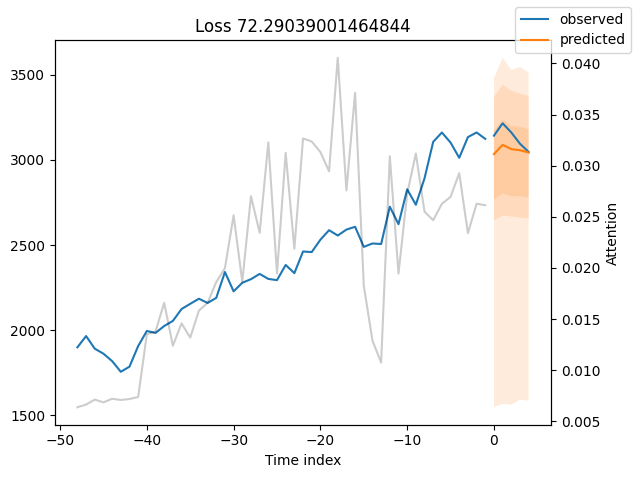

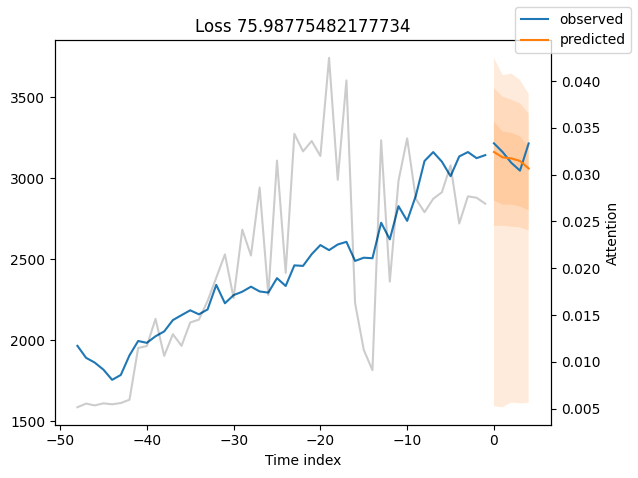

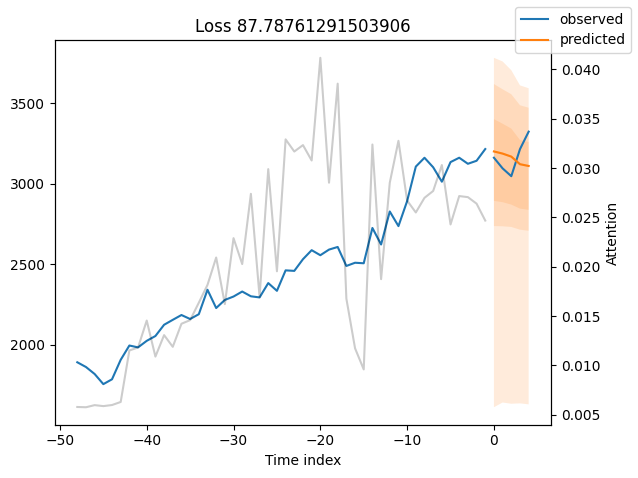

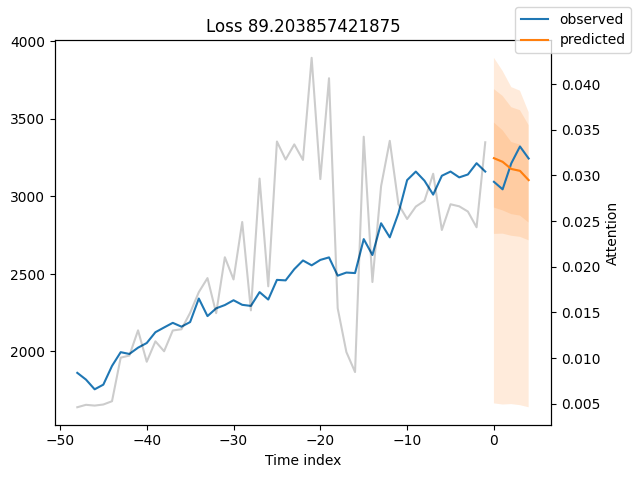

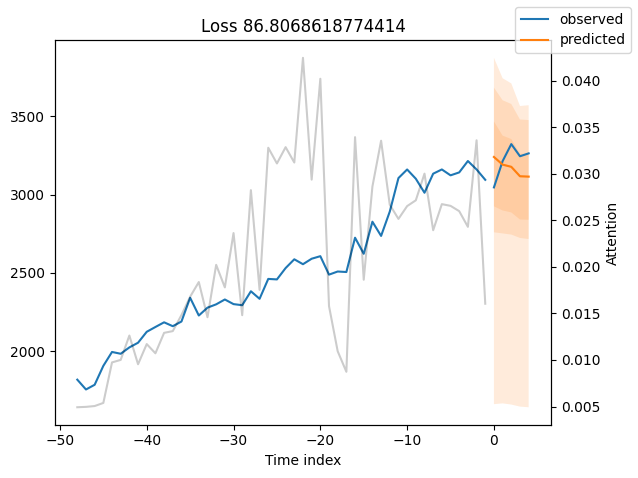

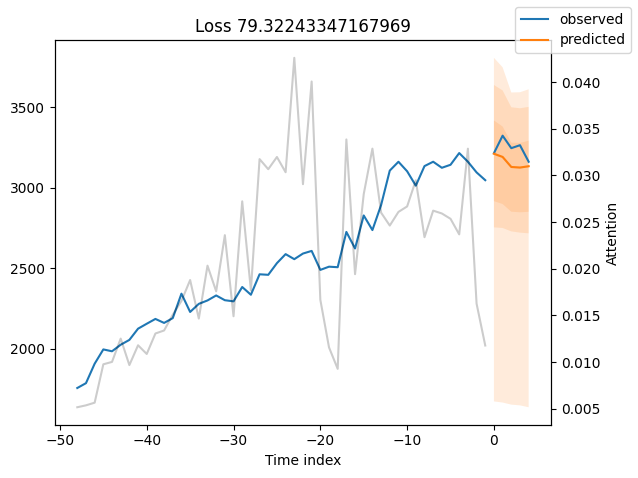

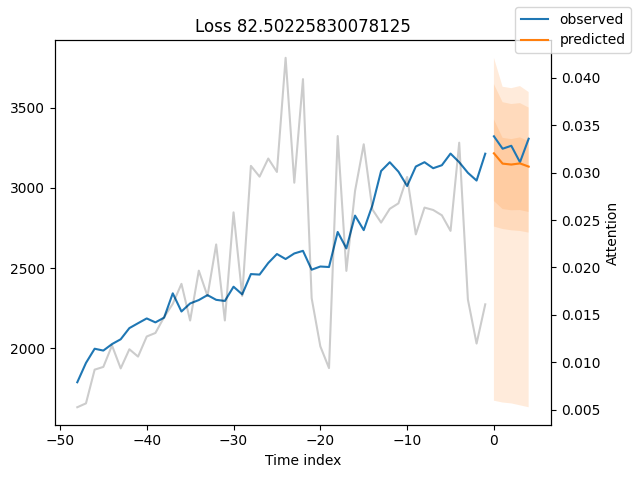

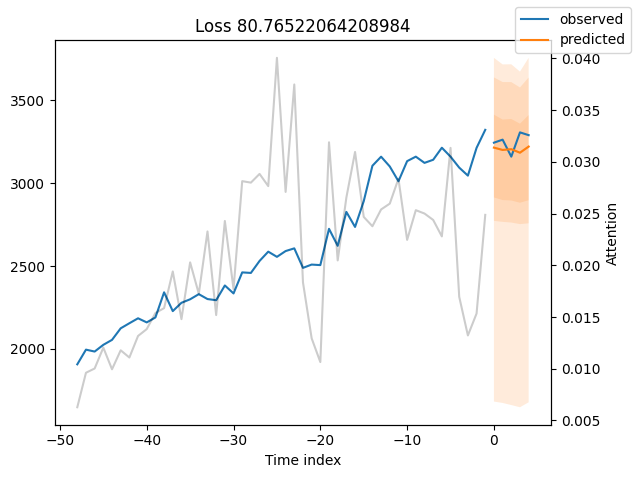

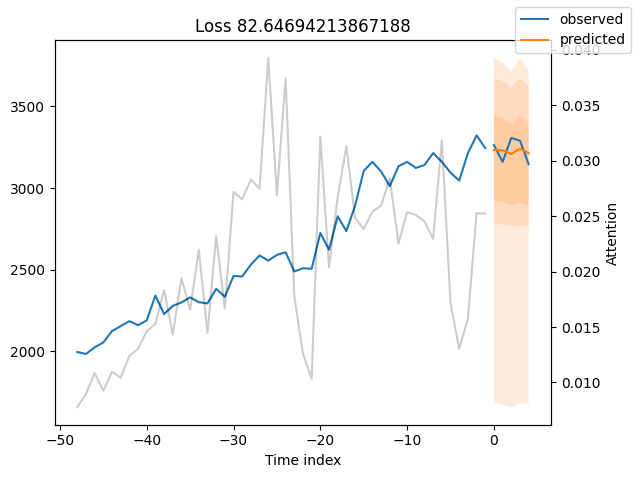

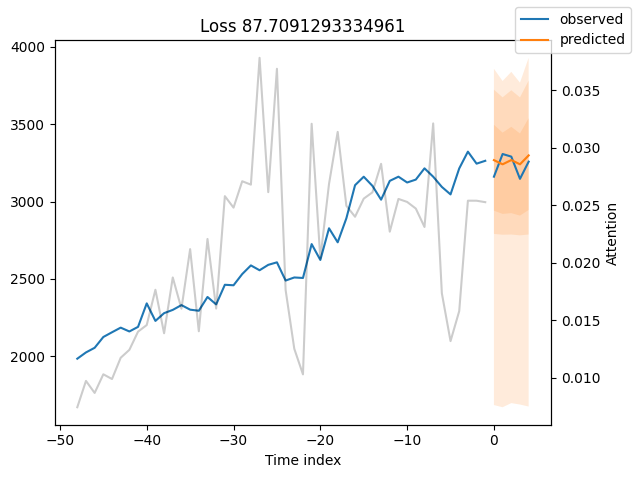

In [34]:
for idx in range(100, 110):  # plot 10 examples
    best_tft.plot_prediction(x, raw_predictions, idx=idx, add_loss_to_title=True)

In [125]:
test_predictions = best_tft.predict(test_dataloader, mode="prediction")

In [124]:
# i don't know why test_loader repeats last obs many times. starting index is ok to make a prediction
for x, (y, weight) in iter(test_dataloader):
    print(y)
    #print(x)


tensor([[2988.0601],
        [2911.8501],
        [3055.5601],
        [3041.5100],
        [3101.7700],
        [3152.7800],
        [3076.0400],
        [3151.1499],
        [2983.5801],
        [3014.3601],
        [2962.3899],
        [2958.7300],
        [2933.0300],
        [2938.8601],
        [2921.0000],
        [2861.7400],
        [3006.6201],
        [3003.0400],
        [2809.6699],
        [2884.7900],
        [2888.9600],
        [2928.2600],
        [2936.9299],
        [2843.1101],
        [2817.1299],
        [2830.7600],
        [2726.6599],
        [2756.8000],
        [2824.8101],
        [2795.0500],
        [2856.5400],
        [2849.0100],
        [2781.7000],
        [2870.5400],
        [2940.6399],
        [2925.6699],
        [2747.9700],
        [2676.0400],
        [2692.8501],
        [2688.8999],
        [2635.3401],
        [2568.0901],
        [2519.7100],
        [2406.0300],
        [2228.5500],
        [2402.0000],
        [2342.0500],
        [2410

In [126]:
test_predictions

tensor([[2465.6536],
        [2416.0859],
        [2447.0435],
        [2445.3792],
        [2468.3127],
        [2501.8494],
        [2557.7722],
        [2529.2090],
        [2586.0208],
        [2546.7905],
        [2550.7852],
        [2505.6375],
        [2522.0603],
        [2438.3616],
        [2475.7668],
        [2444.9417],
        [2483.3062],
        [2496.8188],
        [2533.5562],
        [2510.4160],
        [2517.2915],
        [2501.6201],
        [2512.1641],
        [2499.5298],
        [2503.4634],
        [2460.6777],
        [2476.5442],
        [2377.2612],
        [2401.6707],
        [2355.2332],
        [2359.3604],
        [2337.9832],
        [2338.6968],
        [2314.1943],
        [2356.8264],
        [2398.3230],
        [2438.7278],
        [2401.3428],
        [2397.8979],
        [2346.8442],
        [2362.3398],
        [2244.7886],
        [2276.6682],
        [2241.3787],
        [2281.4736],
        [2225.8245],
        [2262.4666],
        [2238

In [105]:
df[lambda x: x.time_idx >validation_cutoff]

,time_idx,open,high,low,close,volume,SMA_3,EMA_3,VAR_3,SMA_5,EMA_5,VAR_5,SMA_10,EMA_10,VAR_10,SMA_13,EMA_13,VAR_13,SMA_20,EMA_20,VAR_20,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9,RSI_14,RSI_10,RSI_6,STOCHk_14_3_3,STOCHd_14_3_3,WILLR_14,BBL_5_2_0,BBM_5_2_0,BBU_5_2_0,BBB_5_2_0,BBP_5_2_0,roc_1,hour,weekday,hour_sin,hour_cos,weekday_sin,weekday_cos,group_id
3101,3101,3048.05,3083.00,2981.70,2988.06,180002.2177,3031.803333,3018.354882,1466.750033,3035.090,3028.119884,753.77490,3042.986,3047.906988,1267.401316,3036.786923,3063.117308,1262.170640,3095.1815,3097.762812,9127.793192,-60.237814,-3.599255,-56.638559,38.233522,35.237273,30.884440,24.160787,26.286058,-85.563100,2985.977072,3035.090,3084.202928,3.236341,0.021205,0.980319,12,6,-2.449294e-16,1.0,-2.449294e-16,1.0,1
3102,3102,2988.07,3002.39,2883.22,2911.85,223103.9359,2982.653333,2965.102441,4659.534033,3009.348,2989.363256,3715.00587,3032.762,3023.169354,2969.220196,3031.564615,3041.507692,2262.199044,3077.8510,3080.056830,9177.458757,-67.424909,-8.629080,-58.795829,33.674036,29.034422,21.297105,17.607212,23.155383,-89.063336,2900.315808,3009.348,3118.380192,7.246234,0.052894,0.974495,0,0,0.000000e+00,1.0,0.000000e+00,1.0,1
3103,3103,2911.86,3069.60,2895.00,3055.56,287147.7177,2985.156667,3010.331220,5169.463033,3012.564,3011.428838,4008.98043,3026.490,3029.058562,2170.669156,3032.686923,3043.515165,2301.444273,3071.0095,3077.723799,8463.857900,-60.823403,-1.622059,-59.201344,46.605023,48.155883,53.770762,30.402490,24.056830,-34.166094,2899.299984,3012.564,3125.828016,7.519443,0.689804,1.049354,12,0,-2.449294e-16,1.0,0.000000e+00,1.0,1
3104,3104,3055.56,3095.18,3030.34,3041.51,142804.8794,3002.973333,3025.920610,6276.947033,3009.006,3021.455892,3656.56053,3023.363,3031.322460,1946.786379,3033.752308,3043.228713,2304.596036,3062.6055,3074.274866,7424.548489,-56.078937,2.497926,-58.576862,45.667611,46.786451,51.288045,45.745792,31.251831,-39.533196,2900.834868,3009.006,3117.177132,7.189825,0.650243,0.995402,0,1,0.000000e+00,1.0,8.660254e-01,0.5,1
3105,3105,3041.51,3131.00,3040.88,3101.77,216570.1244,3066.280000,3063.845305,994.005700,3019.750,3048.227261,5282.45005,3031.342,3044.131104,2558.908662,3040.496923,3051.591754,2608.632056,3054.7655,3076.893450,5419.414847,-46.915620,9.328994,-56.244614,50.286227,53.137258,60.641179,69.928948,48.692410,-16.513867,2889.735231,3019.750,3149.764769,8.610962,0.815426,1.019813,12,1,-2.449294e-16,1.0,8.660254e-01,0.5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3673,3673,1586.19,1586.19,1555.99,1572.10,179099.7576,1585.300000,1580.924272,163.398400,1587.166,1584.828798,150.11068,1587.916,1589.352911,632.269271,1597.658462,1588.645597,822.348681,1597.3270,1577.937505,1481.808148,26.611660,-12.942440,39.554099,52.342325,47.797679,40.783758,43.881548,44.729057,-62.917266,1565.249016,1587.166,1609.082984,2.761776,0.156294,0.991123,12,5,-2.449294e-16,1.0,-8.660254e-01,0.5,1
3674,3674,1572.10,1619.79,1566.33,1609.08,246526.2483,1589.120000,1595.002136,348.362800,1588.764,1592.912532,218.50508,1586.264,1592.939655,521.218160,1596.246154,1591.564797,757.147142,1601.8005,1580.903457,1150.121668,26.227928,-10.660937,36.888865,58.196522,56.649355,57.508965,48.233854,45.404001,-37.569402,1562.321302,1588.764,1615.206698,3.328713,0.884151,1.023523,0,6,0.000000e+00,1.0,-2.449294e-16,1.0,1
3675,3675,1609.08,1660.00,1603.52,1644.72,305241.6651,1608.633333,1619.861068,1318.565733,1601.940,1610.181688,759.64340,1595.139,1602.354263,711.409410,1596.865385,1599.158398,816.367277,1606.4820,1586.981223,1088.658501,28.471467,-6.733919,35.205385,62.923549,63.311238,67.971180,62.917590,51.677664,-10.760563,1552.636259,1601.940,1651.243741,6.155504,0.933841,1.022149,12,6,-2.449294e-16,1.0,-2.449294e-16,1.0,1
3676,3676,1644.73,1647.53,1577.00,1581.55,284500.1191,1611.783333,1600.705534,1003.093233,1598.726,1600.637792,846.00358,1598.745,1

In [81]:
test_predictions.shape

torch.Size([589, 1])

{'attention': <Figure size 640x480 with 1 Axes>,
 'static_variables': <Figure size 700x275 with 1 Axes>,
 'encoder_variables': <Figure size 700x1250 with 1 Axes>,
 'decoder_variables': <Figure size 700x375 with 1 Axes>}

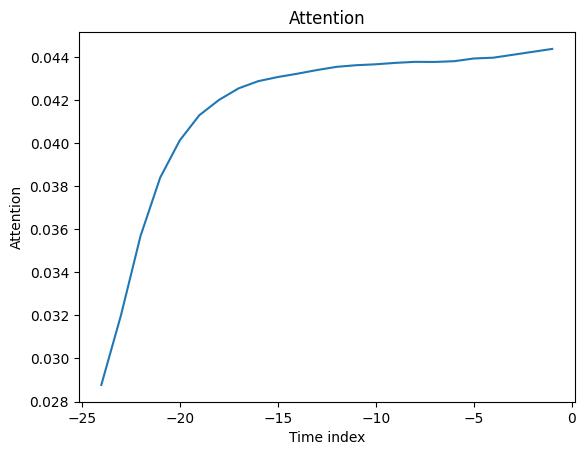

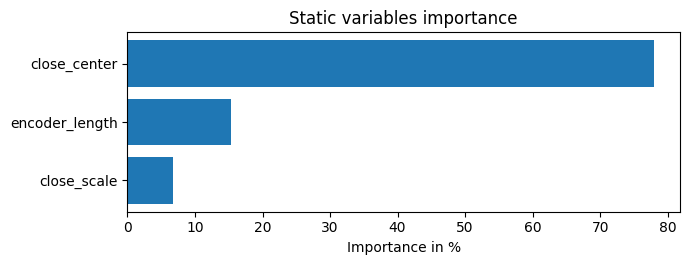

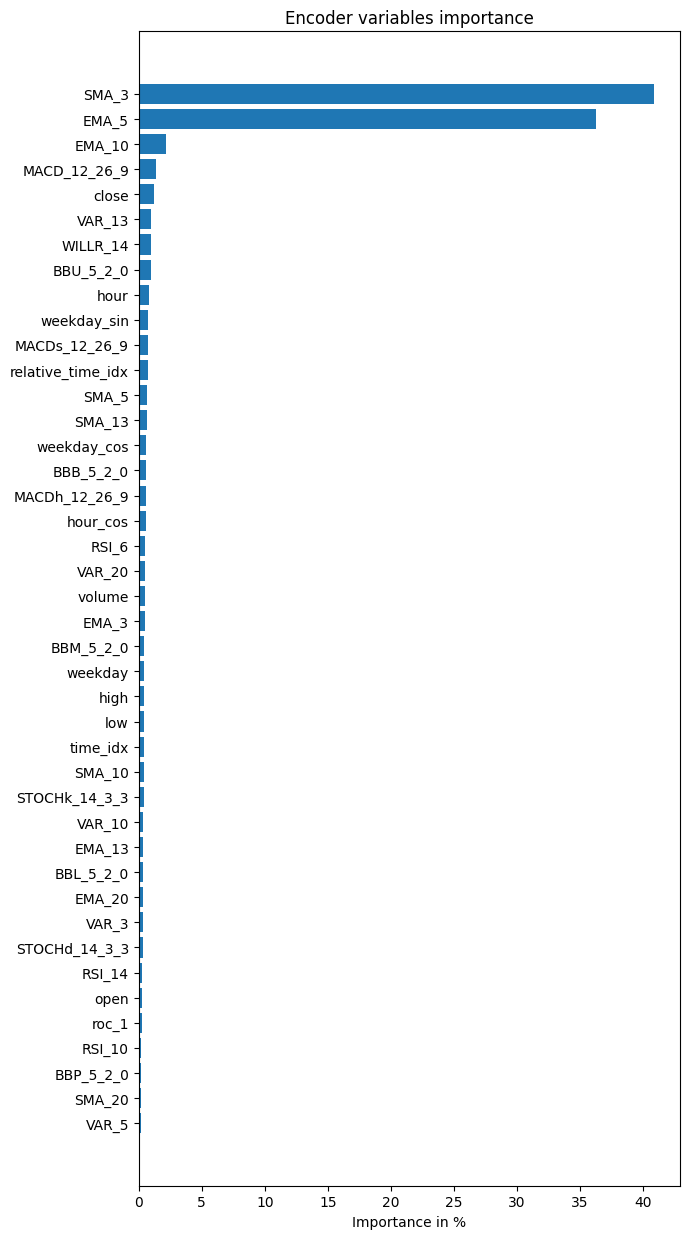

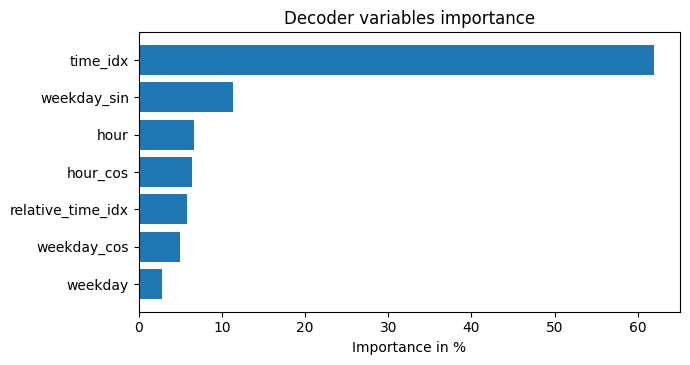

In [102]:
interpretation = best_tft.interpret_output(raw_predictions, reduction="sum")
best_tft.plot_interpretation(interpretation)

In [23]:
training.data

{'reals': tensor([[ 0.0000e+00,  0.0000e+00,  2.2737e-13,  ...,  5.7137e+00,
          -3.6570e-01,  4.7060e+00],
         [ 0.0000e+00,  0.0000e+00,  2.2737e-13,  ...,  3.3494e+00,
           1.5452e-01,  6.4557e-01],
         [ 0.0000e+00,  0.0000e+00,  2.2737e-13,  ...,  1.8620e+00,
           2.4601e-01, -8.4533e-01],
         ...,
         [ 0.0000e+00,  0.0000e+00,  2.2737e-13,  ..., -8.8339e-01,
           1.3070e+00,  6.6074e-01],
         [ 0.0000e+00,  0.0000e+00,  2.2737e-13,  ..., -5.0826e-01,
           1.4800e+00,  6.2087e-01],
         [ 0.0000e+00,  0.0000e+00,  2.2737e-13,  ..., -4.6134e-01,
          -6.0529e-01, -1.1374e+00]]),
 'categoricals': tensor([], size=(3677, 0), dtype=torch.int64),
 'groups': tensor([[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]]),
 'target': [tensor([1000.0000, 1023.0000,  994.0000,  ..., 1609.0800, 1644.7200,
          1581.5500])],
 'weight': None,
 'time': tensor([   0,    1,    2,  ..., 3674, 36

In [ ]:
training.filter()

In [73]:
for X_batch, y_batch in train_dataloader:
    print(X_batch, y_batch)
    break

{'encoder_cat': tensor([], size=(128, 24, 0), dtype=torch.int64), 'encoder_cont': tensor([[[ 1.0000e+00,  0.0000e+00,  2.2737e-13,  ..., -6.3494e-01,
          -1.0040e+00, -1.7140e-01],
         [ 1.0000e+00,  0.0000e+00,  2.2737e-13,  ..., -8.3413e-01,
           2.4377e-01,  3.7628e-01],
         [ 1.0000e+00,  0.0000e+00,  2.2737e-13,  ..., -1.0734e+00,
           6.3034e-01, -9.4736e-02],
         ...,
         [ 1.0000e+00,  0.0000e+00,  2.2737e-13,  ..., -8.5195e-01,
           9.5456e-01,  1.1000e-01],
         [ 1.0000e+00,  0.0000e+00,  2.2737e-13,  ..., -7.4106e-01,
           1.0801e+00,  1.5433e-01],
         [ 1.0000e+00,  0.0000e+00,  2.2737e-13,  ..., -7.9782e-01,
           2.6621e-01, -2.3156e-01]],

        [[ 1.0000e+00,  0.0000e+00,  2.2737e-13,  ...,  2.2279e+00,
          -1.4117e+00, -1.7576e+00],
         [ 1.0000e+00,  0.0000e+00,  2.2737e-13,  ...,  2.5197e+00,
          -8.0091e-01,  5.3729e-01],
         [ 1.0000e+00,  0.0000e+00,  2.2737e-13,  ...,  1.6268

In [35]:
X_batch.keys()

dict_keys(['encoder_cat', 'encoder_cont', 'encoder_target', 'encoder_lengths', 'decoder_cat', 'decoder_cont', 'decoder_target', 'decoder_lengths', 'decoder_time_idx', 'groups', 'target_scale'])

In [52]:
X_batch['decoder_cont'].numpy().shape

(128, 1, 45)

In [57]:
X_batch['target_scale']

tensor([[1151.0889, 1196.1604],
        [1151.0889, 1196.1604],
        [1151.0889, 1196.1604],
        [1151.0889, 1196.1604],
        [1151.0889, 1196.1604],
        [1151.0889, 1196.1604],
        [1151.0889, 1196.1604],
        [1151.0889, 1196.1604],
        [1151.0889, 1196.1604],
        [1151.0889, 1196.1604],
        [1151.0889, 1196.1604],
        [1151.0889, 1196.1604],
        [1151.0889, 1196.1604],
        [1151.0889, 1196.1604],
        [1151.0889, 1196.1604],
        [1151.0889, 1196.1604],
        [1151.0889, 1196.1604],
        [1151.0889, 1196.1604],
        [1151.0889, 1196.1604],
        [1151.0889, 1196.1604],
        [1151.0889, 1196.1604],
        [1151.0889, 1196.1604],
        [1151.0889, 1196.1604],
        [1151.0889, 1196.1604],
        [1151.0889, 1196.1604],
        [1151.0889, 1196.1604],
        [1151.0889, 1196.1604],
        [1151.0889, 1196.1604],
        [1151.0889, 1196.1604],
        [1151.0889, 1196.1604],
        [1151.0889, 1196.1604],
        

In [53]:
X_batch['decoder_target']

tensor([[3076.0400],
        [ 165.6400],
        [3944.7300],
        [ 214.3900],
        [ 104.8400],
        [1541.8199],
        [1959.0800],
        [2491.1201],
        [ 103.8900],
        [ 179.1700],
        [1567.5900],
        [ 132.1000],
        [ 485.5700],
        [ 241.9500],
        [ 243.1300],
        [4069.6299],
        [ 182.9500],
        [ 220.9400],
        [ 430.8900],
        [ 174.1200],
        [ 207.8400],
        [3596.9800],
        [ 414.7000],
        [ 190.9900],
        [ 191.2000],
        [ 346.3300],
        [ 225.4000],
        [1311.7900],
        [ 203.2900],
        [ 743.9600],
        [ 697.9200],
        [1085.4399],
        [1779.1400],
        [ 384.3900],
        [ 455.9200],
        [ 208.6700],
        [3406.8101],
        [ 150.7300],
        [ 207.4200],
        [ 211.7700],
        [3128.4199],
        [ 184.8800],
        [ 170.8200],
        [2874.3899],
        [4444.5298],
        [1361.4900],
        [ 211.4100],
        [ 790

In [54]:
X_batch['decoder_lengths']

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1])

In [55]:
X_batch['decoder_time_idx']

tensor([[3107],
        [1453],
        [2865],
        [ 541],
        [ 754],
        [3286],
        [3167],
        [3019],
        [ 750],
        [1206],
        [2278],
        [ 805],
        [ 341],
        [1016],
        [1773],
        [2856],
        [1644],
        [1783],
        [1885],
        [1642],
        [1215],
        [2720],
        [ 392],
        [1314],
        [ 960],
        [1851],
        [ 523],
        [3435],
        [1695],
        [ 222],
        [  38],
        [3538],
        [2296],
        [1949],
        [ 318],
        [ 550],
        [2899],
        [1365],
        [1104],
        [1666],
        [2904],
        [1151],
        [ 474],
        [2976],
        [2823],
        [3441],
        [1143],
        [  96],
        [1108],
        [1220],
        [1416],
        [1680],
        [1839],
        [2670],
        [1800],
        [2585],
        [2526],
        [3054],
        [2837],
        [3159],
        [ 834],
        [  48],
        

In [75]:
df.head(1)

,time_idx,open,high,low,close,volume,SMA_3,EMA_3,VAR_3,SMA_5,EMA_5,VAR_5,SMA_10,EMA_10,VAR_10,SMA_13,EMA_13,VAR_13,SMA_20,EMA_20,VAR_20,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9,RSI_14,RSI_10,RSI_6,STOCHk_14_3_3,STOCHd_14_3_3,WILLR_14,BBL_5_2_0,BBM_5_2_0,BBU_5_2_0,BBB_5_2_0,BBP_5_2_0,roc_1,hour,weekday,hour_sin,hour_cos,weekday_sin,weekday_cos,group_id
0,0,857.05,1070.0,755.0,1000.0,253177.13121,953.32,991.816701,6537.0672,1053.796,1040.926957,24407.91848,1193.312,1116.488676,33147.439929,1195.84,1132.647918,25465.066817,1205.3395,1123.674694,18055.182858,31.45986,-76.896583,108.356443,43.774715,40.629094,37.192771,27.38317,33.148149,-63.542209,774.322675,1053.796,1333.269325,53.041257,0.403755,1.162845,12,2,-2.449294e-16,1.0,0.866025,-0.5,1


In [74]:
pd.DataFrame(X_batch['encoder_cont'].numpy()[0])

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44
0,1.0,0.0,2.273737e-13,1.523376,1.000272,-1.001020,0.0,1.324001,0.481041,-1.000000,0.113556,0.097414,0.128616,0.107863,-0.357707,0.112685,0.114612,-0.265043,0.124040,0.121345,-0.292414,0.137687,0.132559,-0.349369,0.146139,0.136483,-0.344153,0.145333,0.143154,-0.358045,-0.256382,-0.198899,-0.208345,-0.919199,-1.118889,-1.536551,-1.661712,-1.460868,-1.517846,0.152842,0.124040,0.097706,-0.634938,-1.004043,-0.171398
1,1.0,0.0,2.273737e-13,1.524318,-0.999728,-0.501054,0.0,1.324001,-0.866094,-0.958333,0.108029,0.104664,0.134112,0.122551,-0.553354,0.114818,0.118697,-0.258378,0.119781,0.121883,-0.311332,0.132906,0.130884,-0.361957,0.142624,0.134641,-0.345282,0.145325,0.141349,-0.358027,-0.256403,-0.158083,-0.221326,-0.561469,-0.568547,-0.525433,-1.354038,-1.550460,-0.978383,0.157021,0.119781,0.085810,-0.834133,0.243771,0.376276
2,1.0,0.0,2.273737e-13,1.525260,1.000272,-0.501054,0.0,1.324001,-0.866094,-0.916667,0.122710,0.103617,0.142923,0.119843,-0.379300,0.116971,0.119384,-0.257293,0.116341,0.121337,-0.325429,0.129836,0.129021,-0.365036,0.137834,0.132674,-0.354762,0.146069,0.139456,-0.360630,-0.257790,-0.129073,-0.232004,-0.610145,-0.637789,-0.636407,-1.269797,-1.467637,-1.077863,0.163696,0.116341,0.073211,-1.073396,0.630342,-0.094736
3,1.0,0.0,2.273737e-13,1.526202,-0.999728,-0.001088,0.0,0.001079,-1.539662,-0.875000,0.120010,0.098354,0.087020,0.076914,0.090608,0.106649,0.098247,-0.150839,0.108485,0.106644,-0.279055,0.122574,0.119670,-0.345082,0.130810,0.124833,-0.341612,0.143722,0.133633,-0.349487,-0.321467,-0.272082,-0.254033,-1.255844,-1.452821,-1.640520,-1.231679,-1.320333,-1.410589,0.131667,0.108485,0.087272,-0.511090,-1.684962,-1.174055
4,1.0,0.0,2.273737e-13,1.527144,1.000272,-0.001088,0.0,0.001079,-1.539662,-0.833333,0.077080,0.100340,0.060906,0.113690,1.134235,0.103693,0.106081,-0.171728,0.108545,0.109124,-0.278932,0.120195,0.118723,-0.347659,0.126447,0.123385,-0.352220,0.142212,0.131886,-0.347356,-0.311868,-0.190959,-0.269623,-0.473045,-0.403183,-0.228862,-0.844831,-1.145910,0.110116,0.131689,0.108545,0.087367,-0.510155,0.261661,1.005241
5,1.0,0.0,2.273737e-13,1.528086,-0.999728,0.498879,0.0,-1.321842,-0.866094,-0.791667,0.113857,0.133376,0.141102,0.146118,0.045091,0.112457,0.126224,-0.053522,0.116203,0.121601,-0.235207,0.120428,0.123861,-0.346346,0.126110,0.126793,-0.353538,0.141210,0.133411,-0.349091,-0.251588,0.009181,-0.269328,0.066194,0.243093,0.498454,-0.116260,-0.750777,0.972166,0.127293,0.116203,0.105930,-0.224705,1.149332,0.852818
6,1.0,0.0,2.273737e-13,1.529028,1.000272,0.498879,0.0,-1.321842,-0.866094,-0.750000,0.146286,0.134291,0.146779,0.121373,0.146249,0.127284,0.123913,-0.216806,0.115967,0.121660,-0.235769,0.118179,0.123553,-0.353348,0.123949,0.126167,-0.357686,0.138474,0.132421,-0.352150,-0.239336,0.041130,-0.266498,-0.304611,-0.226094,-0.114589,0.588590,-0.127262,0.572695,0.127184,0.115967,0.105580,-0.227719,0.195405,-0.670450
7,1.0,0.0,2.273737e-13,1.529970,-0.999728,0.998845,0.0,-1.321842,0.481041,-0.708333,0.121531,0.100430,0.135624,0.113974,-0.642317,0.127379,0.119056,-0.217482,0.114793,0.119229,-0.236622,0.115869,0.121953,-0.358058,0.122140,0.124569,-0.358776,0.136476,0.130817,-0.351661,-0.238443,0.036382,-0.264044,-0.408857,-0.355155,-0.280186,0.679211,0.394783,0.365102,0.126162,0.114793,0.104269,-0.231487,-0.047834,-0.220473
8,1.0,0.0,2.273737e-13,1.530913,1.000272,0.998845,0.0,-1.321842,0.481041,-0.666667,0.114132,0.092347,0.124142,0.103524,-0.599821,0.113173,0.111398,-0.253833,0.120119,0.114121,-0.291102,0.114603,0.118738,-0.356730,0.119035,0.121701,-0.360864,0.133233,0.128365,-0.352492,-0.251104,-0.003586,-0.264763,-0.555626,-0.536787,-0.516420,0.359258,0.557667,0.071891,0.148213,0.120119,0.094434,-0.620583,-1.013200,-0.304154
9,1.0,0.0,2.273737e-13,1.531855,-0.999728,1.498811,0.0,0.001079,1.154609,-0.625000,0.103699,0.091096,0.133614,0.111140,-0.774696,0.109760,0.111380,-

In [47]:
X_batch['encoder_target']

tensor([[3192.3899, 3209.5901, 3258.5701,  ..., 3041.5100, 3101.7700,
         3152.7800],
        [ 127.1900,  132.4600,  134.3500,  ...,  142.7700,  143.5800,
          151.5600],
        [4436.9102, 4304.0400, 4105.6401,  ..., 3925.3601, 3924.1399,
         3813.0200],
        ...,
        [3151.9500, 3431.0400, 3480.0100,  ..., 3717.9099, 3999.8201,
         4075.0100],
        [1770.1400, 1766.1100, 1748.9200,  ..., 1245.7800, 1308.5000,
         1326.4600],
        [ 144.6000,  145.6900,  147.1000,  ...,  130.6000,  124.5200,
          125.6500]])

In [95]:
import random


In [122]:
sample_data = pd.DataFrame(
    dict(
        time_idx=np.arange(18),
        variable = np.array(random.sample(range(10, 30), 18)),
        target=np.arange(10, 28),
        group=np.repeat(1, 18),
        holidays = np.tile(['X','Black Friday', 'X','Christmas','X', 'X'],3),
    )
)
sample_data

,time_idx,variable,target,group,holidays
0,0,16,10,1,X
1,1,26,11,1,Black Friday
2,2,12,12,1,X
3,3,19,13,1,Christmas
4,4,29,14,1,X
5,5,13,15,1,X
6,6,18,16,1,X
7,7,22,17,1,Black Friday
8,8,11,18,1,X
9,9,21,19,1,Christmas


In [181]:
max_prediction_length = 1
max_encoder_length = 3
training_cutoff =  8 # sample_data["time_idx"].max() - max_prediction_length
print(training_cutoff)

8


In [182]:
dataset = TimeSeriesDataSet(
    sample_data[lambda x: x.time_idx <= training_cutoff],
    group_ids=["group"],
    target="target",
    time_idx="time_idx",
    max_encoder_length=2,
    max_prediction_length=3,
    time_varying_unknown_reals=["target", "variable"],
    static_categoricals=["holidays"],
    target_normalizer=None
)

In [186]:
validation = TimeSeriesDataSet.from_dataset(dataset,
                                             sample_data, 
                                             stop_randomization=True,
                                             min_prediction_idx=training_cutoff + 1)

In [187]:
for i in range(10):
    dataloader = dataset.to_dataloader(batch_size=1)
    x, y = next(iter(dataloader))
    print(x['encoder_target'])
    print(x['decoder_target'])

tensor([[11., 12.]])
tensor([[13., 14., 15.]])
tensor([[11., 12.]])
tensor([[13., 14., 15.]])
tensor([[12., 13.]])
tensor([[14., 15., 16.]])
tensor([[10., 11.]])
tensor([[12., 13., 14.]])
tensor([[13., 14.]])
tensor([[15., 16., 17.]])
tensor([[13., 14.]])
tensor([[15., 16., 17.]])
tensor([[12., 13.]])
tensor([[14., 15., 16.]])
tensor([[12., 13.]])
tensor([[14., 15., 16.]])
tensor([[14., 15.]])
tensor([[16., 17., 18.]])
tensor([[10., 11.]])
tensor([[12., 13., 14.]])


In [188]:
for i in range(10):
    dataloader = validation.to_dataloader(batch_size=1)
    x, y = next(iter(dataloader))
    print(x['encoder_target'])
    print(x['decoder_target'])

tensor([[22., 23.]])
tensor([[24., 25., 26.]])
tensor([[20., 21.]])
tensor([[22., 23., 24.]])
tensor([[23., 24.]])
tensor([[25., 26., 27.]])
tensor([[18., 19.]])
tensor([[20., 21., 22.]])
tensor([[20., 21.]])
tensor([[22., 23., 24.]])
tensor([[19., 20.]])
tensor([[21., 22., 23.]])
tensor([[22., 23.]])
tensor([[24., 25., 26.]])
tensor([[20., 21.]])
tensor([[22., 23., 24.]])
tensor([[19., 20.]])
tensor([[21., 22., 23.]])
tensor([[18., 19.]])
tensor([[20., 21., 22.]])


In [152]:
y

(tensor([[17., 18., 19.]]), None)

In [100]:
x.keys()

dict_keys(['encoder_cat', 'encoder_cont', 'encoder_target', 'encoder_lengths', 'decoder_cat', 'decoder_cont', 'decoder_target', 'decoder_lengths', 'decoder_time_idx', 'groups', 'target_scale'])

In [101]:
x['encoder_cont']

tensor([[[ 0.0000, -0.7214],
         [ 1.0000, -1.2550]]])

In [ ]:
TimeSeriesDataSet